In [2]:
%pip install gensim klib nltk scikit-learn spacy imblearn
%pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [3]:
# Standard libraries
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Related third-party imports
from gensim.models import Word2Vec
import klib
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier


In [4]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="SHS/tokenization-practice")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/266M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForTokenClassification.

All the layers of TFDistilBertForTokenClassification were initialized from the model checkpoint at SHS/tokenization-practice.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForTokenClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [5]:
import concurrent.futures

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
zip_file_path = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'

In [8]:
df = pd.read_csv(zip_file_path)

In [9]:
df.head(8)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-02-08,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77406,NaN,NaN,Phone,2024-02-08,In progress,Yes,NaN,8309609
1,2024-03-02,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",SC,29481,NaN,NaN,Web,2024-03-02,In progress,Yes,NaN,8452526
2,2024-01-22,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,TN,37217,NaN,NaN,Web,2024-01-22,In progress,Yes,NaN,8195574
3,2024-01-29,Debt or credit management,Debt settlement,Problem with customer service,NaN,NaN,NaN,"Progress Law, LLC",VA,22306,NaN,NaN,Web,2024-03-01,Closed with explanation,Yes,NaN,8238318
4,2024-02-21,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,GA,30213,NaN,NaN,Web,2024-02-21,In progress,Yes,NaN,8394514
5,2024-02-21,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,FL,32818,NaN,NaN,Web,2024-02-21,In progress,Yes,NaN,8388503
6,2024-02-29,Debt collection,I do not know,Written notification about debt,Didn't receive notice of right to dispute,NaN,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",VA,23847,NaN,Consent not provided,Web,2024-02-29,Closed with explanation,Yes,NaN,8453694
7,2024-03-03,"Payday loan, title loan, personal loan, or adv...",Payday loan,Received a loan you didn't apply for,NaN,NaN,NaN,Klarna AB,NJ,07508,NaN,NaN,Web,2024-03-03,Closed with explanation,Yes,NaN,8461976


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4814048 entries, 0 to 4814047
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 661.

In [11]:
df.isnull().sum()


Date received                         0
Product                               0
Sub-product                      235290
Issue                                 0
Sub-issue                        729596
Consumer complaint narrative    3098494
Company public response         2525909
Company                               0
State                             44627
ZIP code                          30225
Tags                            4347315
Consumer consent provided?       976401
Submitted via                         0
Date sent to company                  0
Company response to consumer          9
Timely response?                      0
Consumer disputed?              4045732
Complaint ID                          0
dtype: int64

In [12]:
# To drop the duplicate rows, dropping missing data, reducing memory usage.
df = klib.data_cleaning(df)

Shape of cleaned data: (4814048, 17) - Remaining NAs: 11686283


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 1
     of which 0 single valued.     Columns: []
Dropped missing values: 4347315
Reduced memory by at least: 498.51 MB (-75.41%)



In [13]:
# to clean the column names like converting it into lowercase
df = klib.clean_column_names(df)

In [14]:
# Converting the datatypes into appropriate datatypes
df = klib.convert_datatypes(df)

In [15]:
# Dropping Rows which have missing values in all columns
df = klib.drop_missing(df)

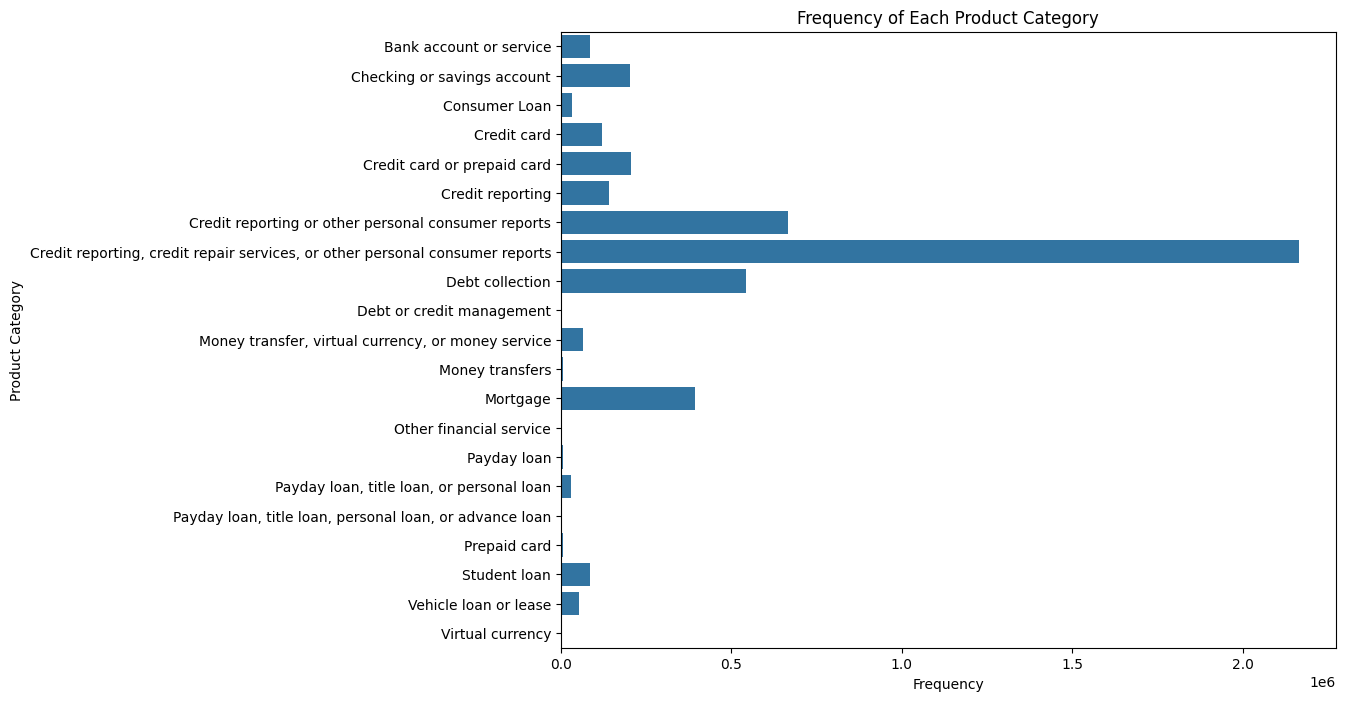

In [16]:
product_counts = df['product'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=product_counts.values, y=product_counts.index, orient='h')
plt.title('Frequency of Each Product Category')
plt.xlabel('Frequency')
plt.ylabel('Product Category')
plt.show()

In [17]:
state_counts = df['state'].value_counts()

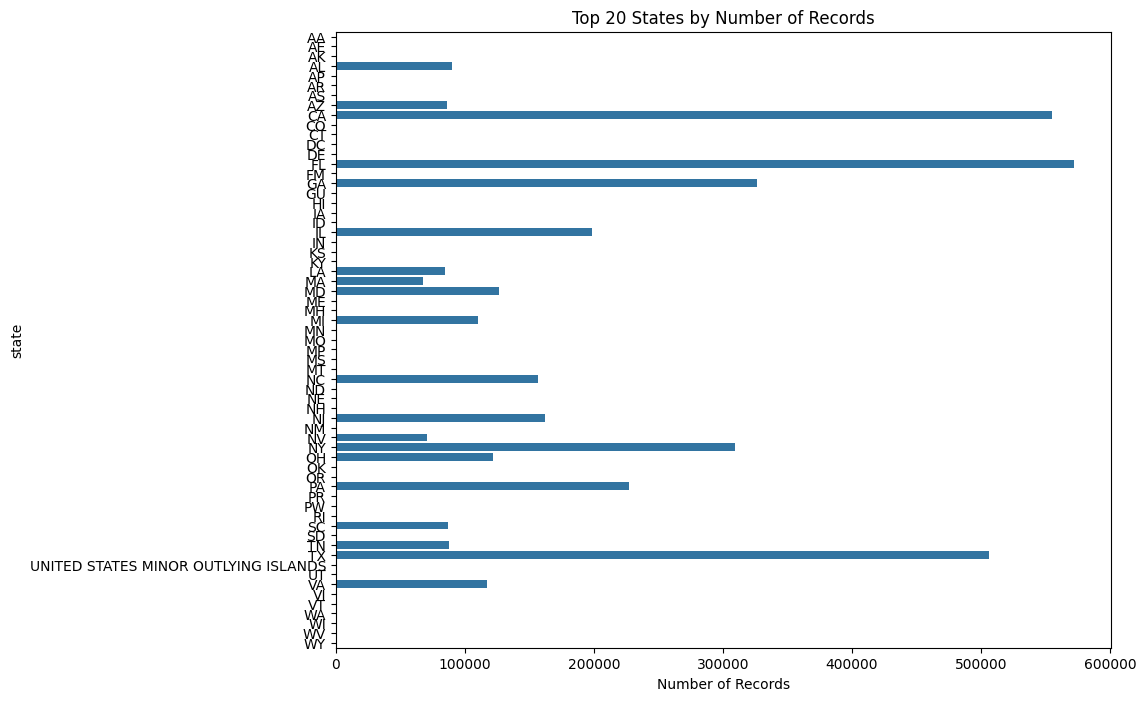

In [18]:
plt.figure(figsize=(10, 8))
sns.barplot(y=state_counts.index[:20], x=state_counts.values[:20], orient='h')
plt.title('Top 20 States by Number of Records')
plt.xlabel('Number of Records')
plt.ylabel('state')
plt.show()


Most complaint against Company

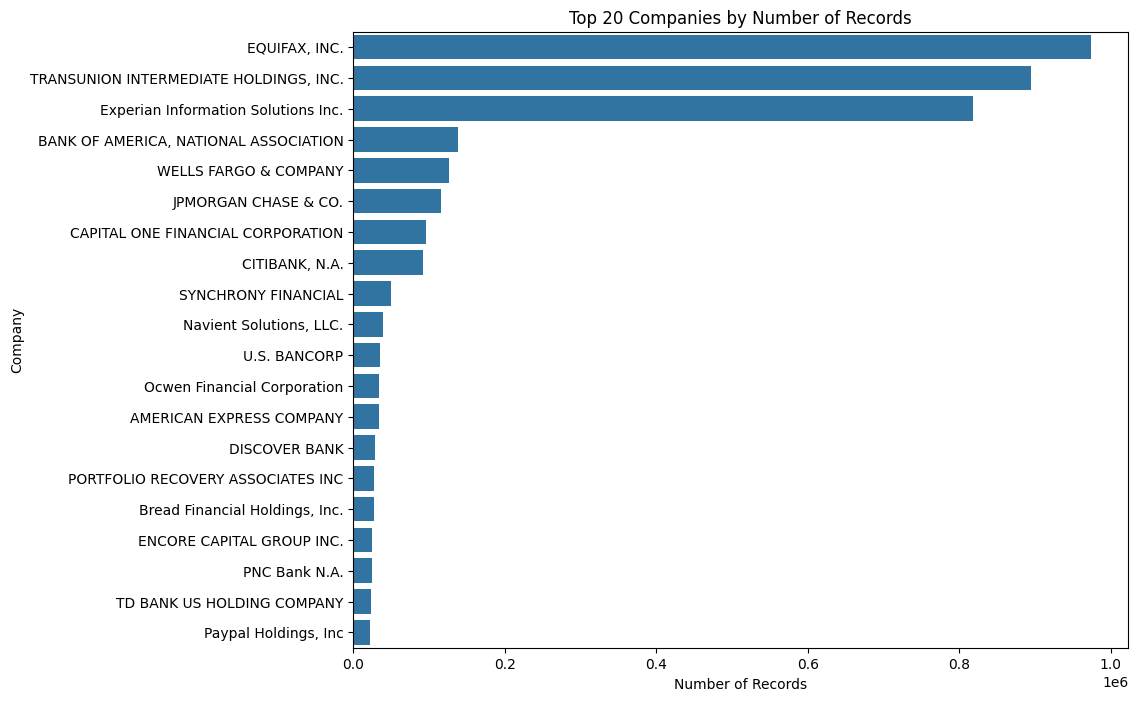

In [19]:
plt.figure(figsize=(10, 8)) # Adjust the size as needed
sns.countplot(y='company', data=df, order=df['company'].value_counts().index[:20])
plt.title('Top 20 Companies by Number of Records')
plt.xlabel('Number of Records')
plt.ylabel('Company')
plt.show()

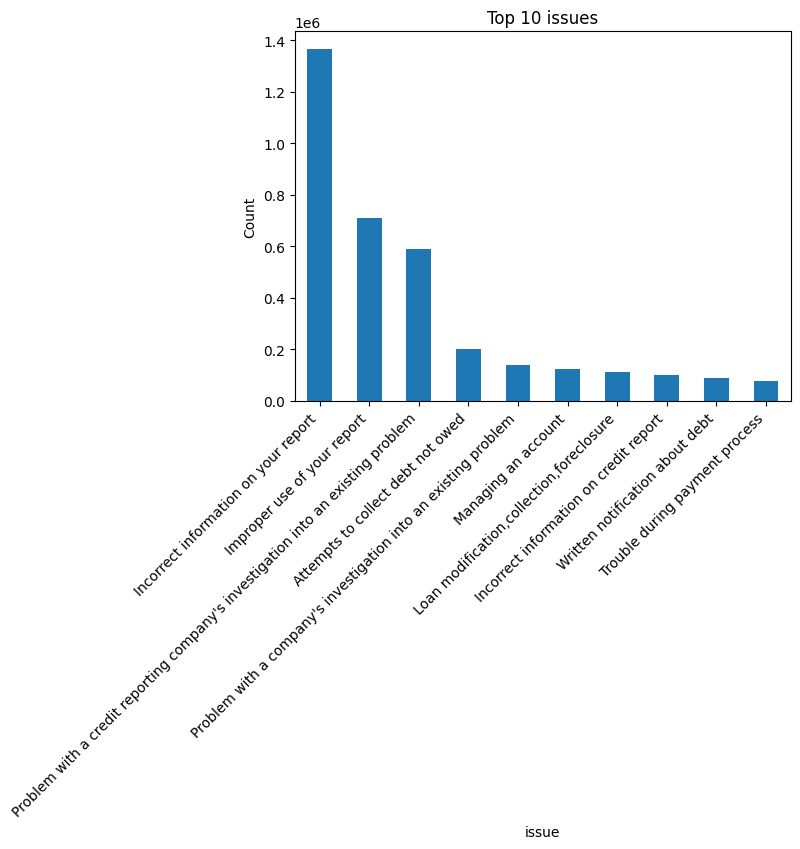

In [20]:
df['issue'].value_counts()
df['issue'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 issues')
plt.xlabel('issue')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

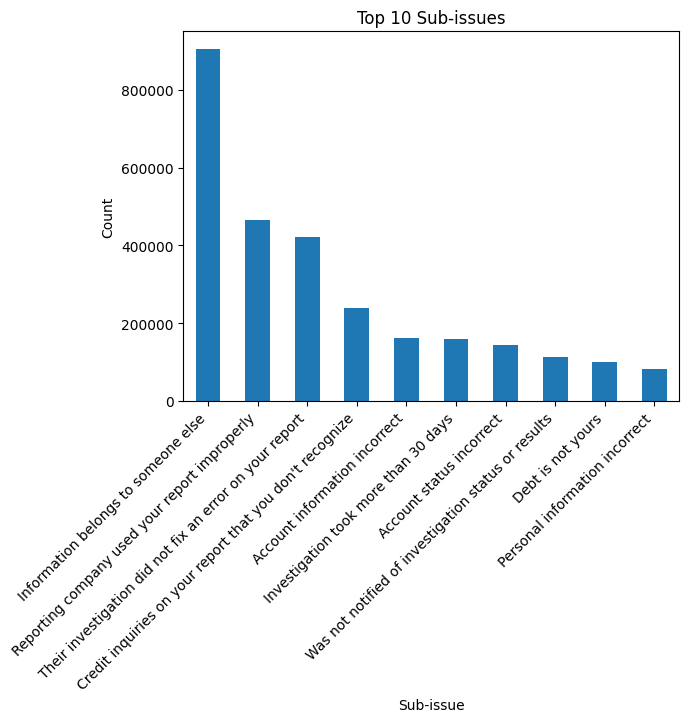

In [21]:
df['sub_issue'].value_counts()
df['sub_issue'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Sub-issues')
plt.xlabel('Sub-issue')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

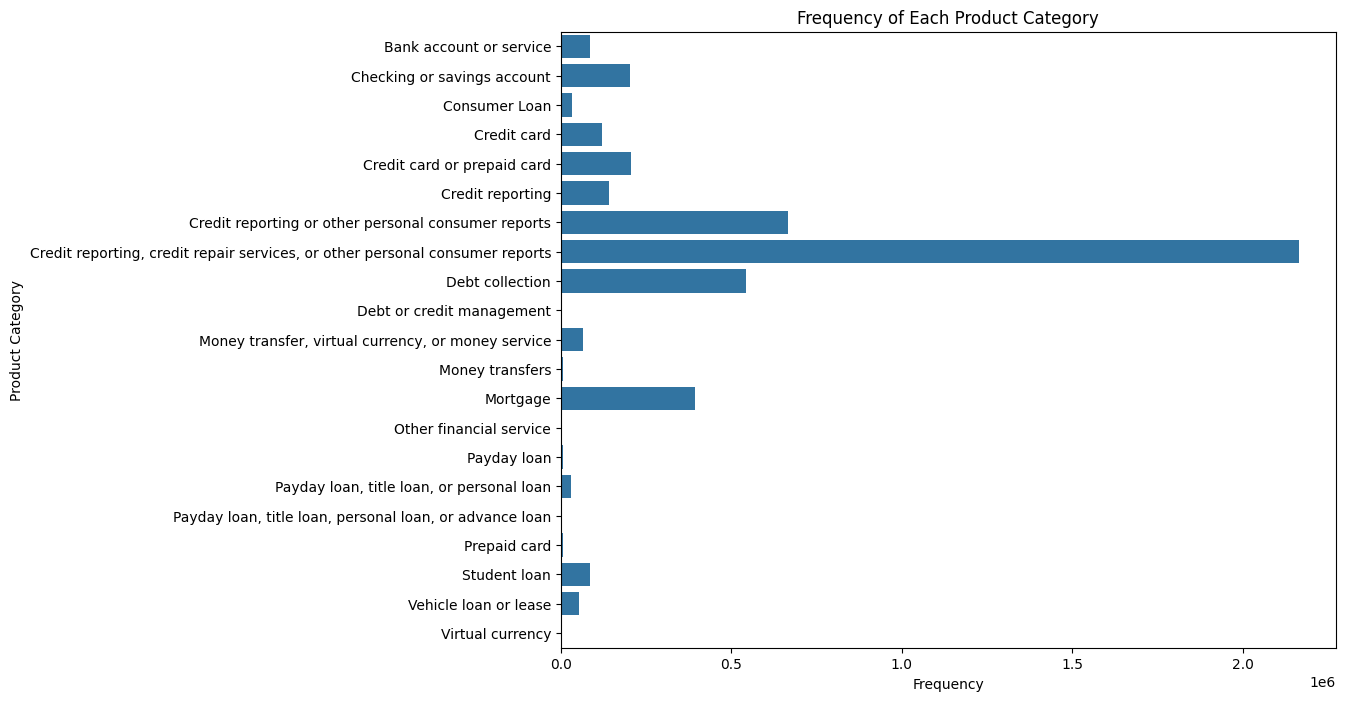

In [22]:
product_counts = df['product'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=product_counts.values, y=product_counts.index, orient='h')
plt.title('Frequency of Each Product Category')
plt.xlabel('Frequency')
plt.ylabel('Product Category')
plt.show()

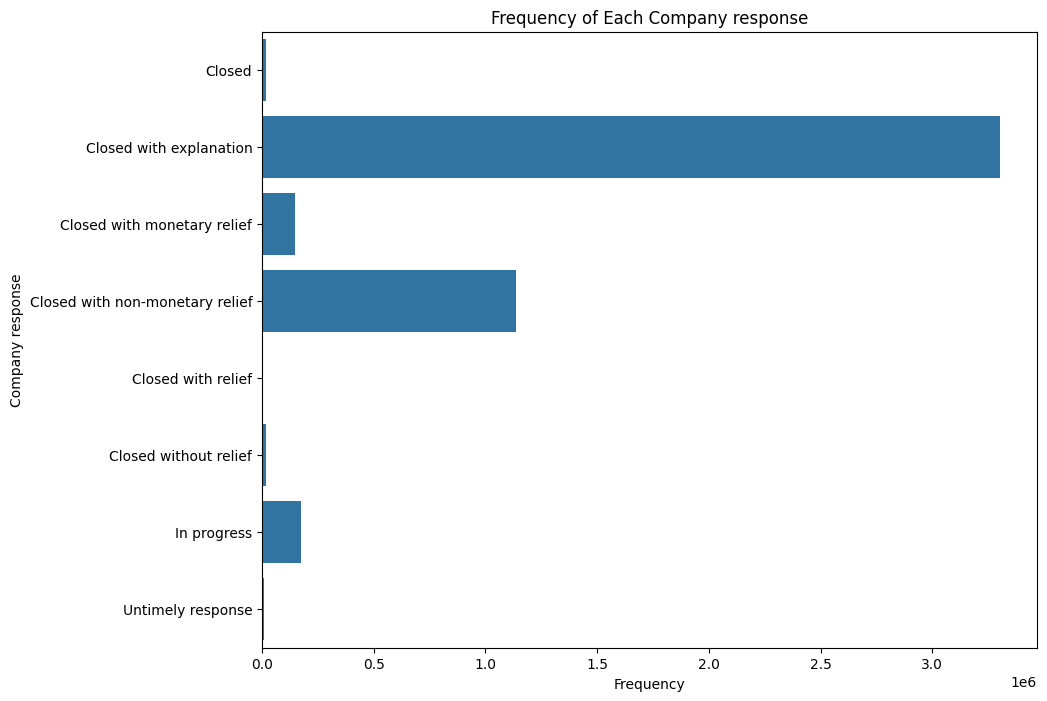

In [23]:
company_response = df['company_response_to_consumer'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=company_response.values, y=company_response.index, orient='h')
plt.title('Frequency of Each Company response')
plt.xlabel('Frequency')
plt.ylabel('Company response')
plt.show()

In [24]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'consumer_consent_provided', 'submitted_via',
       'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object')

In [25]:
df[df['consumer_disputed'] == 'Yes'].shape[0]
df.shape[0]-df['consumer_disputed'].isnull().sum()
# Count the number of null values in the column
null_count = df['consumer_disputed'].isnull().sum()
print(f"Number of null values in 'Consumer disputed': {null_count}")

Number of null values in 'Consumer disputed': 4045732


In [26]:
#Calculate the percentage of null values
total_rows = len(df)
null_percentage = (null_count / total_rows) * 100
print(f"Percentage of null values: {null_percentage:.2f}%")

Percentage of null values: 84.04%


In [27]:
columns_to_convert = [
    'date_received', 'product', 'sub_product', 'issue', 'sub_issue',
    'company_public_response', 'company', 'state', 'zip_code', 'tags',
    'consumer_consent_provided', 'submitted_via', 'date_sent_to_company',
    'company_response_to_consumer', 'timely_response'
]

# Convert specified columns to object, only if they exist in the DataFrame
for column in columns_to_convert:
    if column in df.columns:
        df[column] = df[column].astype('object')


In [28]:
# I want to drop all those rows which have null values in my target column
df.dropna(subset = ['consumer_disputed'], inplace=True)

In [29]:
df.isnull().sum()

date_received                        0
product                              0
sub_product                     235159
issue                                0
sub_issue                       455365
consumer_complaint_narrative    604305
company_public_response         572607
company                              0
state                             5650
zip_code                          3857
consumer_consent_provided       470515
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed                    0
complaint_id                         0
dtype: int64

In [30]:
df.shape

(768316, 17)

In [31]:
df.head(5)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
2982,2013-05-05,Consumer Loan,Vehicle loan,Problems when you are unable to pay,NaN,<NA>,NaN,NISSAN MOTOR ACCEPTANCE COMPANY LLC,NV,89169,NaN,Web,2013-05-06,Closed with explanation,Yes,Yes,398344
5920,2013-03-15,Student loan,Non-federal student loan,Repaying your loan,NaN,<NA>,NaN,DISCOVER BANK,VA,05201,NaN,Referral,2013-03-19,Closed with monetary relief,Yes,No,357780
6120,2012-10-09,Mortgage,FHA mortgage,"Loan servicing, payments, escrow account",NaN,<NA>,NaN,"SUNTRUST BANKS, INC.",GA,30906,NaN,Referral,2012-10-10,Closed with explanation,Yes,No,167803
6590,2013-02-05,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,<NA>,NaN,WELLS FARGO & COMPANY,OH,45723,NaN,Phone,2013-02-06,Closed with explanation,Yes,No,301488
19682,2012-01-12,Credit card,NaN,Billing disputes,NaN,<NA>,NaN,JPMORGAN CHASE & CO.,NY,11768,NaN,Web,2012-01-12,Closed with relief,Yes,No,13055


In [32]:
clean_df = df.drop(columns=['consumer_consent_provided','complaint_id', 'date_sent_to_company',
                              'zip_code','state','date_received','sub_product','consumer_complaint_narrative',
                              'sub_issue'])
clean_df.dropna(inplace = True)

In [33]:
clean_df.isnull().sum()

product                         0
issue                           0
company_public_response         0
company                         0
submitted_via                   0
company_response_to_consumer    0
timely_response                 0
consumer_disputed               0
dtype: int64

In [34]:
clean_df.shape

(195709, 8)

In [35]:
clean_df = clean_df.reset_index(drop=True)

<ipython-input-36-1126d60529dd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=consumer_disputed_counts.index, y=consumer_disputed_counts.values ,palette='viridis')


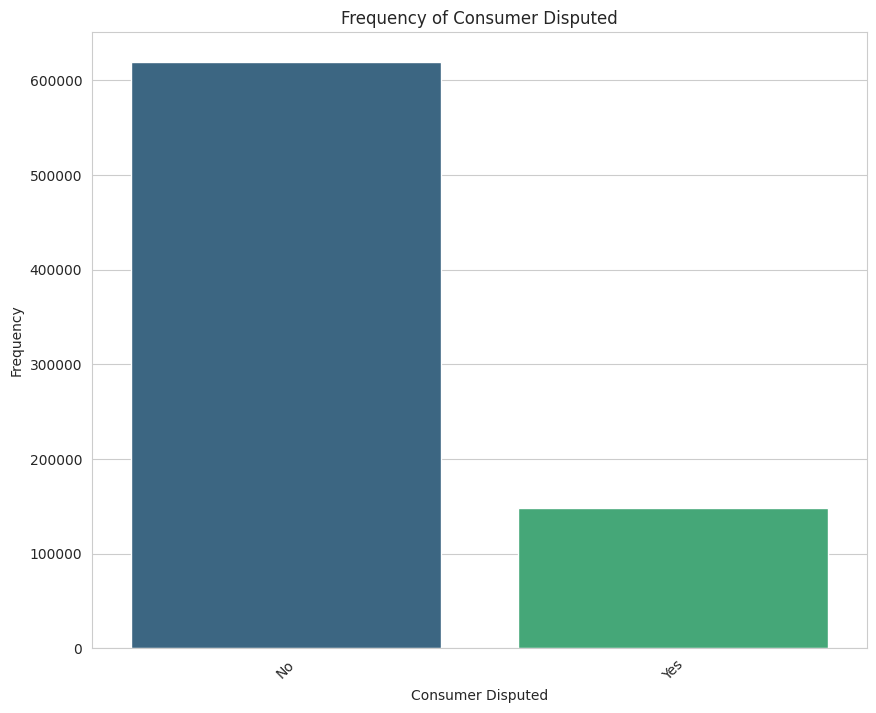

In [36]:
consumer_disputed_counts = df['consumer_disputed'].value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x=consumer_disputed_counts.index, y=consumer_disputed_counts.values ,palette='viridis')
plt.title('Frequency of Consumer Disputed')
plt.ylabel('Frequency')
plt.xlabel('Consumer Disputed')
plt.xticks(rotation=45)
plt.show()

In [37]:
"""plt.figure(figsize=(10, 8))
# Assuming consumer_disputed is a Series with indices as categories and values as counts
sns.barplot(x=consumer_disputed.index, y=consumer_disputed.values)
plt.title('Frequency of Consumer Disputed')
plt.ylabel('Frequency')  # Correcting label for clarity
plt.xlabel('Consumer Disputed')  # Adjusting label for clarity
plt.xticks(rotation=45)  # Optional: Rotate labels if they overlap
plt.show()#
"""

"plt.figure(figsize=(10, 8))\n# Assuming consumer_disputed is a Series with indices as categories and values as counts\nsns.barplot(x=consumer_disputed.index, y=consumer_disputed.values)\nplt.title('Frequency of Consumer Disputed')\nplt.ylabel('Frequency')  # Correcting label for clarity\nplt.xlabel('Consumer Disputed')  # Adjusting label for clarity\nplt.xticks(rotation=45)  # Optional: Rotate labels if they overlap\nplt.show()#\n"

To tackle the imbalance observed in our dataframe, consider personalizing our approach with the following tailored solutions:

- Deploying the Synthetic Minority Over-sampling Technique (SMOTE), which creatively amplifies the minority class to balance our dataset.
- Opting for a Random Over Sampler approach, directly boosting the representation of our less prevalent class.
- Harnessing the power of sophisticated algorithms like Random Forests or Support Vector Machines, renowned for their adept handling of imbalanced datasets.
- Adopting Stratified Sampling, a technique ensuring that each class is proportionately represented, mirroring the original distribution.
- Exploring Ensemble Methods, including the nuanced strategies of Bagging and Boosting, to refine our model's performance substantially.
- Fine-tuning class weights, a strategic move to harshly penalize misclassifications of our minority class, thereby encouraging a more balanced predictive outcome.

In [38]:
columns_to_display = [
    'product',
    'timely_response',
    # 'tags', # Supposez que cette colonne pourrait ne pas exister
    'company_response_to_consumer',
    'submitted_via',
    'consumer_disputed',
    'company_public_response'
]

for column in columns_to_display:
    print(f"{column.upper()}:")
    # Vérifier si la colonne existe dans le DataFrame
    if column in clean_df.columns:
        for value in clean_df[column].unique():
            print(value)
    else:
        print(f"La colonne '{column}' n'existe pas dans le DataFrame.")
    print('```````````````````````````````````````````````````````\n')


PRODUCT:
Mortgage
Credit card
Credit reporting
Payday loan
Debt collection
Consumer Loan
Bank account or service
Student loan
Other financial service
Prepaid card
Money transfers
Checking or savings account
Virtual currency
```````````````````````````````````````````````````````

TIMELY_RESPONSE:
Yes
No
```````````````````````````````````````````````````````

COMPANY_RESPONSE_TO_CONSUMER:
Closed with explanation
Closed with monetary relief
Closed with non-monetary relief
Closed
```````````````````````````````````````````````````````

SUBMITTED_VIA:
Web
Referral
Phone
Fax
Postal mail
Email
```````````````````````````````````````````````````````

CONSUMER_DISPUTED:
No
Yes
```````````````````````````````````````````````````````

COMPANY_PUBLIC_RESPONSE:
Company believes it acted appropriately as authorized by contract or law
Company has responded to the consumer and the CFPB and chooses not to provide a public response
Company chooses not to provide a public response
Company believes the 

Executing a comprehensive suite of Natural Language Processing (NLP) preprocessing steps:

Eliminating punctuation marks
Segmenting text into tokens
Converting text to lowercase
Filtering out stop words
Applying lemmatization to reduce words to their base or dictionary form

In [39]:
df = pd.DataFrame.copy(clean_df)

In [40]:
stemmer = PorterStemmer()

def preprocess_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

def parallel_preprocess(column):
    df[column] = df[column].apply(preprocess_text)

columns_to_preprocess = ['product', 'issue', 'company_public_response', 'company', 'tags', 'submitted_via', 'company_response_to_consumer', 'timely_response']
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(parallel_preprocess, columns_to_preprocess)

In [41]:
df['consumer_disputed'] = df['consumer_disputed'].apply(lambda x: 1 if x == 'Yes' else 0)

In [42]:
df.head(3)

,product,issue,company_public_response,company,submitted_via,company_response_to_consumer,timely_response,consumer_disputed
0,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0
1,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0
2,Mortgage,Settlement process and costs,Company believes it acted appropriately as aut...,"NETWORK FUNDING, L.P.",Referral,Closed with monetary relief,Yes,0


In [43]:
nltk.download('punkt')
df['combined_text'] = df['product'].astype(str) + ' ' + df['issue'].astype(str) + ' ' + \
                      df['company_public_response'].astype(str) + ' ' + df['company'].astype(str) + ' ' + \
                      df['submitted_via'].astype(str) + ' ' + df['company_response_to_consumer'].astype(str) + ' ' + \
                      df['timely_response'].astype(str)

# Tokenize the combined text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df[['combined_text', 'tokenized_text']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,combined_text,tokenized_text
0,"Mortgage Loan servicing, payments, escrow acco...","[Mortgage, Loan, servicing, ,, payments, ,, es..."
1,"Mortgage Loan servicing, payments, escrow acco...","[Mortgage, Loan, servicing, ,, payments, ,, es..."
2,Mortgage Settlement process and costs Company ...,"[Mortgage, Settlement, process, and, costs, Co..."
3,Credit card Identity theft / Fraud / Embezzlem...,"[Credit, card, Identity, theft, /, Fraud, /, E..."
4,Credit reporting Incorrect information on cred...,"[Credit, reporting, Incorrect, information, on..."


In [44]:
# Define a preprocessing function
def preprocess_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenization
    tokens = word_tokenize(text)
    # Lower casing
    tokens = [word.lower() for word in tokens]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [45]:
# Apply text preprocessing to a column (example: 'consumer_complaint_narrative')
if 'consumer_complaint_narrative' in df.columns:
    df['preprocessed_text'] = df['consumer_complaint_narrative'].astype(str).apply(preprocess_text)

In [49]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [50]:
# Example of combining relevant columns for NLP tasks
columns_to_combine = ['product', 'issue', 'company_public_response', 'company']
df['combined_text'] = df[columns_to_combine].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df['combined_text'] = df['combined_text'].apply(preprocess_text)

In [51]:
# Tokenize the combined text for further processing or modeling
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)

In [52]:
df.head()

,product,issue,company_public_response,company,submitted_via,company_response_to_consumer,timely_response,consumer_disputed,combined_text,tokenized_text
0,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0,mortgage loan servicing payment escrow account...,"[mortgage, loan, servicing, payment, escrow, a..."
1,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0,mortgage loan servicing payment escrow account...,"[mortgage, loan, servicing, payment, escrow, a..."
2,Mortgage,Settlement process and costs,Company believes it acted appropriately as aut...,"NETWORK FUNDING, L.P.",Referral,Closed with monetary relief,Yes,0,mortgage settlement process cost company belie...,"[mortgage, settlement, process, cost, company,..."
3,Credit card,Identity theft / Fraud / Embezzlement,Company has responded to the consumer and the ...,"CITIBANK, N.A.",Web,Closed with monetary relief,Yes,1,credit card identity theft fraud embezzlement ...,"[credit, card, identity, theft, fraud, embezzl..."
4,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,Experian Information Solutions Inc.,Web,Closed with non-monetary relief,Yes,0,credit reporting incorrect information credit ...,"[credit, reporting, incorrect, information, cr..."


In [53]:
tokenized_texts = df['tokenized_text'].tolist()
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, sg=1)

# Save the trained Word2Vec model
w2v_model.save("word2vec_model.bin")

In [54]:
# Example of generating document embeddings
def document_embeddings(text, model):
    words = [word for word in text if word in model.wv]
    if words:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)


In [55]:
df['document_embeddings'] = df['tokenized_text'].apply(lambda x: document_embeddings(x, w2v_model))


In [56]:
df.head()

,product,issue,company_public_response,company,submitted_via,company_response_to_consumer,timely_response,consumer_disputed,combined_text,tokenized_text,document_embeddings
0,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0,mortgage loan servicing payment escrow account...,"[mortgage, loan, servicing, payment, escrow, a...","[0.05550443, -0.20948061, -0.21392882, -0.4103..."
1,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE LLC,Web,Closed with explanation,Yes,0,mortgage loan servicing payment escrow account...,"[mortgage, loan, servicing, payment, escrow, a...","[0.05550443, -0.20948061, -0.21392882, -0.4103..."
2,Mortgage,Settlement process and costs,Company believes it acted appropriately as aut...,"NETWORK FUNDING, L.P.",Referral,Closed with monetary relief,Yes,0,mortgage settlement process cost company belie...,"[mortgage, settlement, process, cost, company,...","[-0.035450213, -0.1577336, -0.2715413, -0.3361..."
3,Credit card,Identity theft / Fraud / Embezzlement,Company has responded to the consumer and the ...,"CITIBANK, N.A.",Web,Closed with monetary relief,Yes,1,credit card identity theft fraud embezzlement ...,"[credit, card, identity, theft, fraud, embezzl...","[0.017092317, -0.2352185, -0.10329242, 0.15056..."
4,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,Experian Information Solutions Inc.,Web,Closed with non-monetary relief,Yes,0,credit reporting incorrect information credit ...,"[credit, reporting, incorrect, information, cr...","[0.19012304, -0.20572545, -0.09503539, 0.05135..."


Modelling

In [57]:
# Séparation des caractéristiques et de la cible
X = df.drop(['consumer_disputed'], axis=1)
y = df['consumer_disputed']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Prétraitement pour les caractéristiques numériques
numeric_features = ['document_embeddings']  # Assurez-vous que c'est correctement formaté pour votre cas
numeric_transformer = StandardScaler()

# Prétraitement pour les caractéristiques catégorielles
categorical_features = ['product', 'issue', 'company_public_response', 'company', 'submitted_via', 'company_response_to_consumer', 'timely_response']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Prétraitement pour les données textuelles
text_features = 'combined_text'
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

§§§§§§§§§

In [59]:
l = [len(i) for i in df['document_embeddings']]
print(sorted(l)[int(len(l)/2)])
print(len(df['document_embeddings'][0]))
print(len(df['document_embeddings']))

100
100
195709


In [60]:
X = df['document_embeddings']
y = df['consumer_disputed']
X = np.array(X)
y = np.array(y)

In [61]:
X.shape,y.shape

((195709,), (195709,))

In [62]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, 1), y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [63]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
X_train.shape, X_test.shape

((259524, 1, 100), (64882, 1, 100))

In [64]:
train_class_distribution = np.bincount(y_train)
test_class_distribution = np.bincount(y_test)

print(f"Train Class Distribution: {train_class_distribution}")
print(f"Test Class Distribution: {test_class_distribution}")

Train Class Distribution: [129529 129995]
Test Class Distribution: [32674 32208]


In [65]:
X_train = X_train.reshape(X_train.shape[0], 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 1)

In [66]:
early_stopping = EarlyStopping(monitor = 'accuracy' , patience = 1  ,restore_best_weights = True )
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model_hist= model.fit(X_train, y_train, epochs=10, batch_size=32,
                      validation_data=(X_test, y_test),verbose=1,callbacks=[early_stopping])

Epoch 1/10
8111/8111 [==============================] - 2238s 275ms/step - loss: 0.6871 - accuracy: 0.5484 - val_loss: 0.6841 - val_accuracy: 0.5539
Epoch 2/10
8111/8111 [==============================] - 2276s 281ms/step - loss: 0.6835 - accuracy: 0.5557 - val_loss: 0.6811 - val_accuracy: 0.5595
Epoch 3/10
8111/8111 [==============================] - 2282s 281ms/step - loss: 0.6857 - accuracy: 0.5437 - val_loss: 0.6933 - val_accuracy: 0.4964


In [67]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report

y_pred = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.2).astype('int32')
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

2028/2028 [==============================] - 170s 84ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     32674
           1       0.00      0.00      0.00     32208

    accuracy                           0.50     64882
   macro avg       0.25      0.50      0.33     64882
weighted avg       0.25      0.50      0.34     64882



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


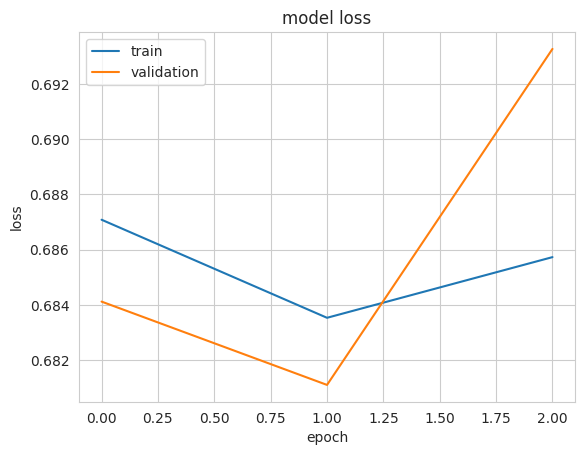

In [68]:
plt.plot(Model_hist.history['loss'])
plt.plot(Model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

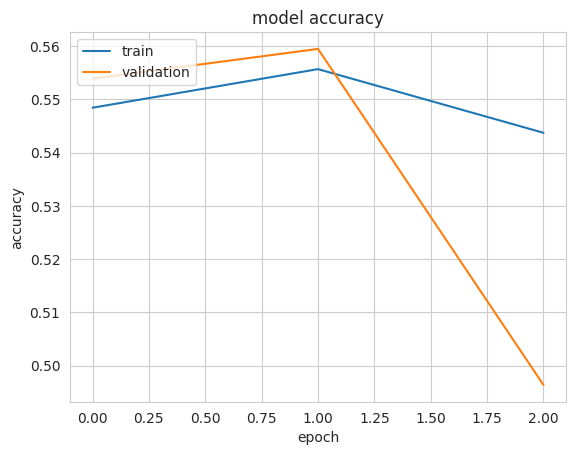

In [69]:
plt.plot(Model_hist.history['accuracy'])
plt.plot(Model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [71]:
model.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
from tensorflow.keras.models import load_model

loaded_model = load_model('lstm_model.h5')


In [73]:
w2v_model = Word2Vec.load("word2vec_model.bin")


example_text = "mortgag Loan servicing, payments, escrow account compani choos provid public respons bank america nation associ older american postal mail close explan ye"


tokenized_text = word_tokenize(example_text.lower())  # Convert to lowercase for consistency

word_embeddings_2 = [w2v_model.wv[word] for word in tokenized_text if word in w2v_model.wv]


In [74]:
document_embeddings_2 = [np.mean(embeddings, axis=0) if embeddings.any() else np.zeros(w2v_model.vector_size) for embeddings in word_embeddings_2]


In [75]:
import numpy as np

# Assuming 'example_text' is the text you want to convert
example_tokens = word_tokenize(example_text)

# Initialize an empty list to store word vectors
example_vectors = []

# Iterate through each token in the example text
for token in example_tokens:
    try:
        vector = w2v_model.wv[token]
        example_vectors.append(vector)
    except KeyError:
        # Handle the case where a token is not in the vocabulary
        pass

# If there are no vectors for any tokens, add a zero vector
if not example_vectors:
    example_vectors.append(np.zeros(w2v_model.vector_size))

# Calculate the mean of the word vectors
example_vector = np.mean(example_vectors, axis=0)

# 'example_vector' now contains the vector representation of the example text

In [76]:
vec = np.array(example_vector)

final_vec= np.expand_dims(vec, axis=-1)

In [77]:
final_vec.shape

(100, 1)

In [78]:
final_vec = vec.reshape((1, vec.shape[0],1))


pred = model.predict(final_vec)

pred


1/1 [==============================] - 0s 55ms/step


array([[0.6008874]], dtype=float32)

In [79]:
pred_class = 'Yes'
if pred[0][0]<0.5:
    pred_class = 'Yes'
else:
    pred_class = 'No'

pred_class


'No'